<a href="https://colab.research.google.com/github/astrorafa/Rubiks-Cube-Solver/blob/main/%20Thistlethwaites%20Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initializing libraries


In [ ]:
pip install permutation

In [ ]:
import time
import pickle
import pandas as pd
import numpy as np
from collections import deque
from permutation import Permutation
from queue import Queue, PriorityQueue
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Defining Cubie Classes

In [ ]:
class CornerCubie:
    
    __slots__ = ['orientation', 'ID']
    
    def __init__(self, ID, orientation = 0):
        self.orientation = orientation
        self.ID          = ID
        
        
    def __eq__(self, other):
        return self.ID == other.ID and self.orientation == other.orientation
    
    
    def __str__(self):
        return str(self.ID) + ' ' + str(self.orientation)
    
    
    def __repr__(self):
        return str(self.ID) + ' ' + str(self.orientation)
    

    def incrementOrientOne(self):
        if   self.orientation == 0: return CornerCubie(self.ID, 1)
        elif self.orientation == 1: return CornerCubie(self.ID, 2)
        elif self.orientation == 2: return CornerCubie(self.ID, 0) 
        
        
    def incrementOrientTwo(self):
        if   self.orientation == 0: return CornerCubie(self.ID, 2)
        elif self.orientation == 1: return CornerCubie(self.ID, 0)
        elif self.orientation == 2: return CornerCubie(self.ID, 1) 


# CORNER GOAL STATE CLASS INSTANCES
WRB = CornerCubie(1)    # Up-Front-Right
WRG = CornerCubie(2)    # Up-Front-Left
YRB = CornerCubie(3)    # Down-Front-Right
YRG = CornerCubie(4)    # Down-Front-Left
WOB = CornerCubie(5)    # Up-Back-Right
WOG = CornerCubie(6)    # Up-Back-Left
YOB = CornerCubie(7)    # Down-Back-Right
YOG = CornerCubie(8)    # Down-Back-Left

In [ ]:
class EdgeCubie:
    
    __slots__ = ['orientation', 'ID']
    
    def __init__(self, ID, orientation = 0):
        self.orientation = orientation
        self.ID          = ID
        
        
    def __eq__(self, other):
        return self.ID == other.ID and self.orientation == other.orientation
    
    
    def __str__(self):
        return str(self.ID) + ' ' + str(self.orientation)
    
    
    def __repr__(self):
        return str(self.ID) + ' ' + str(self.orientation)
    

    def changeOrientation(self):
        if self.orientation == 1  : return EdgeCubie(self.ID, 0)
        elif self.orientation == 0: return EdgeCubie(self.ID, 1)


# EDGE GOAL STATE CLASS INSTANCES
WR = EdgeCubie(1)   # Up-Front
WB = EdgeCubie(2)   # Up-Right
WO = EdgeCubie(3)   # Up-Back
WG = EdgeCubie(4)   # Up-Left
RB = EdgeCubie(5)   # Front-Right
RG = EdgeCubie(6)   # Front-Left
OB = EdgeCubie(7)   # Back-Right
OG = EdgeCubie(8)   # Back-Left
YR = EdgeCubie(9)   # Down-Front
YB = EdgeCubie(10)  # Down-Right
YO = EdgeCubie(11)  # Down-Back
YG = EdgeCubie(12)  # Down-Left

# Defining list classes

In [ ]:
class CornerList:
    
    GOAL = np.array([WRB, WRG, YRB, YRG, WOB, WOG, YOB, YOG])
    
    __slots__ = ['state', 'hashing']
    
    def __init__(self, state):
        self.state     = state
        self.hashing   = self.hashingNumber()
        
        
    def __str__(self):
        return str(list(self.state))
    
    
    def __repr__(self):
        return str(list(self.state))
    
    
    def __eq__(self, other):
        return self.hashing == other.hashing

    def __hash__(self):
        return hash(self.hashing)
        
        
    def hashingNumber(self):
        ori = int(''.join((str(corner.orientation) for corner in self.state[:-1])), 3)
        id = Permutation(*(corner.ID for corner in self.state)).lehmer(8)
        return id*(3**7) + ori


    def isOriented(self):
        for corner in self.state: 
            if corner.orientation != 0: return False
        return True

  
    def rotateCorners(self, move):
        if   "U" in move:
            if "'" in move: new_state = self.rotateCornerUp(-90)
            elif "2" in move: new_state = self.rotateCornerUp(180)
            else: new_state = self.rotateCornerUp(90)
        elif "D" in move:
            if "'" in move: new_state = self.rotateCornerDown(-90)
            elif "2" in move: new_state = self.rotateCornerDown(180)
            else: new_state = self.rotateCornerDown(90)
        elif "F" in move:
            if "'" in move: new_state = self.rotateCornerFront(-90)
            elif "2" in move: new_state = self.rotateCornerFront(180)
            else: new_state = self.rotateCornerFront(90)
        elif "B" in move:
            if "'" in move: new_state = self.rotateCornerBack(-90)
            elif "2" in move: new_state = self.rotateCornerBack(180)
            else: new_state = self.rotateCornerBack(90)
        elif "R" in move:
            if "'" in move: new_state = self.rotateCornerRight(-90)
            elif "2" in move: new_state = self.rotateCornerRight(180)
            else: new_state = self.rotateCornerRight(90)
        elif "L" in move:
            if "'" in move: new_state = self.rotateCornerLeft(-90)
            elif "2" in move: new_state = self.rotateCornerLeft(180)
            else: new_state = self.rotateCornerLeft(90)
        return CornerList(np.array(new_state))


    # ROTATING UP OR DOWN DOESN'T CHANGE CORNER ORIENTATION
    def rotateCornerUp(self, angle):
        nstate = [item for item in self.state]
        if angle == 90   : nstate[1], nstate[5], nstate[0], nstate[4] = nstate[0], nstate[1], nstate[4], nstate[5]
        elif angle == -90: nstate[4], nstate[0], nstate[5], nstate[1] = nstate[0], nstate[1], nstate[4], nstate[5]
        elif angle == 180: nstate[5], nstate[4], nstate[1], nstate[0] = nstate[0], nstate[1], nstate[4], nstate[5]
        return np.array(nstate)


    def rotateCornerDown(self, angle):
        nstate = [item for item in self.state]
        if angle == 90   : nstate[3], nstate[7], nstate[2], nstate[6] = nstate[2], nstate[3], nstate[6], nstate[7]
        elif angle == -90: nstate[6], nstate[2], nstate[7], nstate[3] = nstate[2], nstate[3], nstate[6], nstate[7]
        elif angle == 180: nstate[7], nstate[6], nstate[3], nstate[2] = nstate[2], nstate[3], nstate[6], nstate[7]
        return np.array(nstate)


    # ROTATING F, B, R, L once change orientation of corners
    def rotateCornerFront(self, angle):
        nstate = [item for item in self.state]
        if angle == 90: 
            nstate[0] = nstate[0].incrementOrientOne()
            nstate[1] = nstate[1].incrementOrientTwo()
            nstate[2] = nstate[2].incrementOrientOne()
            nstate[3] = nstate[3].incrementOrientTwo()
            nstate[2], nstate[0], nstate[3], nstate[1] = nstate[0], nstate[1], nstate[2], nstate[3] 
        elif angle == -90: 
            nstate[0] = nstate[0].incrementOrientOne()
            nstate[1] = nstate[1].incrementOrientTwo()
            nstate[2] = nstate[2].incrementOrientOne()
            nstate[3] = nstate[3].incrementOrientTwo()
            nstate[1], nstate[3], nstate[0], nstate[2] = nstate[0], nstate[1], nstate[2], nstate[3]
        elif angle == 180: 
            nstate[3], nstate[2], nstate[1], nstate[0] = nstate[0], nstate[1], nstate[2], nstate[3]
        return np.array(nstate)


    def rotateCornerBack(self, angle):
        nstate = [item for item in self.state]
        if angle == 90: 
            nstate[5] = nstate[5].incrementOrientOne()
            nstate[6] = nstate[6].incrementOrientOne()
            nstate[4] = nstate[4].incrementOrientTwo()
            nstate[7] = nstate[7].incrementOrientTwo()
            nstate[6], nstate[4], nstate[7], nstate[5] = nstate[4], nstate[5], nstate[6], nstate[7]
        elif angle == -90: 
            nstate[5] = nstate[5].incrementOrientOne()
            nstate[6] = nstate[6].incrementOrientOne()
            nstate[4] = nstate[4].incrementOrientTwo()
            nstate[7] = nstate[7].incrementOrientTwo()
            nstate[5], nstate[7], nstate[4], nstate[6] = nstate[4], nstate[5], nstate[6], nstate[7] 
        elif angle == 180: 
            nstate[7], nstate[6], nstate[5], nstate[4] = nstate[4], nstate[5], nstate[6], nstate[7]
        return np.array(nstate)


    def rotateCornerRight(self, angle):
        nstate = [item for item in self.state]
        if angle == 90: 
            nstate[2] = nstate[2].incrementOrientOne()
            nstate[4] = nstate[4].incrementOrientOne()
            nstate[0] = nstate[0].incrementOrientTwo()
            nstate[6] = nstate[6].incrementOrientTwo()
            nstate[4], nstate[0], nstate[6], nstate[2] = nstate[0], nstate[2], nstate[4], nstate[6]  
        elif angle == -90: 
            nstate[2] = nstate[2].incrementOrientOne()
            nstate[4] = nstate[4].incrementOrientOne()
            nstate[0] = nstate[0].incrementOrientTwo()
            nstate[6] = nstate[6].incrementOrientTwo()
            nstate[2], nstate[6], nstate[0], nstate[4] = nstate[0], nstate[2], nstate[4], nstate[6]
        elif angle == 180: 
            nstate[6], nstate[4], nstate[2], nstate[0] = nstate[0], nstate[2], nstate[4], nstate[6]
        return np.array(nstate)


    def rotateCornerLeft(self, angle):
        nstate = [item for item in self.state]
        if angle == 90: 
            nstate[1] = nstate[1].incrementOrientOne()
            nstate[7] = nstate[7].incrementOrientOne()
            nstate[4] = nstate[4].incrementOrientTwo()
            nstate[5] = nstate[5].incrementOrientTwo()
            nstate[5], nstate[1], nstate[7], nstate[3] = nstate[1], nstate[3], nstate[5], nstate[7]
        elif angle == -90:
            nstate[1] = nstate[1].incrementOrientOne()
            nstate[7] = nstate[7].incrementOrientOne()
            nstate[4] = nstate[4].incrementOrientTwo()
            nstate[5] = nstate[5].incrementOrientTwo()
            nstate[3], nstate[7], nstate[1], nstate[5] = nstate[1], nstate[3], nstate[5], nstate[7]
        elif angle == 180: 
            nstate[7], nstate[5], nstate[3], nstate[1] = nstate[1], nstate[3], nstate[5], nstate[7]
        return np.array(nstate)


wrb = CornerCubie(1)    # Up-Front-Right
wrg = CornerCubie(2)    # Up-Front-Left
yrb = CornerCubie(3)    # Down-Front-Right
yrg = CornerCubie(4)    # Down-Front-Left
wob = CornerCubie(5)    # Up-Back-Right
wog = CornerCubie(6)    # Up-Back-Left
yob = CornerCubie(7)    # Down-Back-Right
yog = CornerCubie(8)    # Down-Back-Left


corner_state = CornerList(np.array([wrb, wrg, yrb, yrg, wob, wog, yob, yog]))

In [ ]:
class EdgeList:
    
    GOAL = np.array([WR, WB, WO, WG, RB, RG, OB, OG, YR, YB, YO, YG])
    
    __slots__ = ['state', 'hashing']
    
    def __init__(self, state):
        self.state     = state
        self.hashing   = self.hashingNumber()
        
        
    def __str__(self):
        return str(list(self.state))
    
    
    def __repr__(self):
        return str(list(self.state))
    
    
    def __eq__(self, other):
        return self.hashing == other.hashing
    
        
    def hashingNumber(self):
        ori = int(''.join((str(edge.orientation) for edge in self.state[:-1])), 2)
        id = Permutation(*(edge.ID for edge in self.state)).lehmer(12)
        return id*(2**11) + ori


    def isOriented(self):
        for edge in self.state: 
            if edge.orientation != 0: return False
        return True


    # layer between LEFT and RIGHT faces: UF, UB, DF, DB
    def edgesLayerM(self):
        edgesM = EdgeList.GOAL[0], EdgeList.GOAL[2], EdgeList.GOAL[8], EdgeList.GOAL[10]
        a  = self.state[0] in edgesM
        b  = self.state[2] in edgesM
        c  = self.state[8] in edgesM
        d = self.state[10] in edgesM
        if a and b and c and d: return True
        else: return False


    # layer between up and down faces: FR, FL, BR, BL
    def edgesLayerE(self):
        edgesE = EdgeList.GOAL[4], EdgeList.GOAL[5], EdgeList.GOAL[6], EdgeList.GOAL[7]
        a = self.state[4] in edgesE
        b = self.state[5] in edgesE
        c = self.state[6] in edgesE
        d = self.state[7] in edgesE
        if a and b and c and d: return True
        else: return False
    

    # layer between front and back faces: UR, UL, DR, DL
    def edgesLayerS(self):
        edgesS = EdgeList.GOAL[1], EdgeList.GOAL[3], EdgeList.GOAL[9], EdgeList.GOAL[11]
        a  = self.state[1] in edgesS
        b  = self.state[3] in edgesS
        c  = self.state[9] in edgesS
        d = self.state[11] in edgesS
        if a and b and c and d: return True
        else: return False
                
        
    def rotateEdges(self, move):
        if "U" in move:
            if "'" in move: new_state = self.rotateEdgeUp(-90)
            elif "2" in move: new_state = self.rotateEdgeUp(180)
            else: new_state = self.rotateEdgeUp(90)
        elif "D" in move:
            if "'" in move: new_state = self.rotateEdgeDown(-90)
            elif "2" in move: new_state = self.rotateEdgeDown(180)
            else: new_state = self.rotateEdgeDown(90)
        elif "F" in move:
            if "'" in move: new_state = self.rotateEdgeFront(-90)
            elif "2" in move: new_state = self.rotateEdgeFront(180)
            else: new_state = self.rotateEdgeFront(90)
        elif "B" in move:
            if "'" in move: new_state = self.rotateEdgeBack(-90)
            elif "2" in move: new_state = self.rotateEdgeBack(180)
            else: new_state = self.rotateEdgeBack(90)
        elif "R" in move:
            if "'" in move: new_state = self.rotateEdgeRight(-90)
            elif "2" in move: new_state = self.rotateEdgeRight(180)
            else: new_state = self.rotateEdgeRight(90)
        elif "L" in move:
            if "'" in move: new_state = self.rotateEdgeLeft(-90)
            elif "2" in move: new_state = self.rotateEdgeLeft(180)
            else: new_state = self.rotateEdgeLeft(90)
        return EdgeList(np.array(new_state))


    # Notice that all edges that appear in Up are in the first 4 places of the list
    def rotateEdgeUp(self, angle):
        nstate = [item for item in self.state]
        if angle == 90   : updates = np.array([nstate[1], nstate[2], nstate[3], nstate[0]])
        elif angle == -90: updates = np.array([nstate[3], nstate[0], nstate[1], nstate[2]])
        elif angle == 180: updates = np.array([nstate[2], nstate[3], nstate[0], nstate[1]])
        return np.concatenate((updates, nstate[4:]))



    # Notice that all edges that appear in DOWN are in the first 4 places of the list
    def rotateEdgeDown(self, angle):
        nstate = [item for item in self.state]
        if angle == 90   : updates = np.array([nstate[9], nstate[10], nstate[11], nstate[8]])
        elif angle == -90: updates = np.array([nstate[11], nstate[8], nstate[9], nstate[10]])
        elif angle == 180: updates = np.array([nstate[10], nstate[11], nstate[8], nstate[9]])
        return np.concatenate((nstate[0:8], updates))



    # Rotating Front or Back flip the orientation of all four edges in that face
    # Notice that all edges that appear in Front are in indexes 0, 4, 5, 8
    def rotateEdgeFront(self, angle):
        nstate = [item for item in self.state]
        if angle != 180: 
            for i in [0, 4, 5, 8]: nstate[i] = nstate[i].changeOrientation()
        if angle == 90   : nstate[0], nstate[4], nstate[5], nstate[8] = nstate[5], nstate[0], nstate[8], nstate[4]  
        elif angle == -90: nstate[0], nstate[4], nstate[5], nstate[8] = nstate[4], nstate[8], nstate[0], nstate[5]
        elif angle == 180: nstate[0], nstate[4], nstate[5], nstate[8] = nstate[8], nstate[5], nstate[4], nstate[0]
        return np.array(nstate)



    # Notice that all edges that appear in Back are in indexes 2, 6, 7, 10
    def rotateEdgeBack(self, angle):
        nstate = [item for item in self.state]
        if angle != 180: 
            for i in [2, 6, 7, 10]: nstate[i] = nstate[i].changeOrientation()
        if angle == 90   : nstate[2], nstate[6], nstate[7], nstate[10] = nstate[7], nstate[2], nstate[10], nstate[6]  
        elif angle == -90: nstate[2], nstate[6], nstate[7], nstate[10] = nstate[6], nstate[10], nstate[2], nstate[7]
        elif angle == 180: nstate[2], nstate[6], nstate[7], nstate[10] = nstate[10], nstate[7], nstate[6], nstate[2]
        return np.array(nstate)



    # Notice that all edges that appear in Right are in indexes 1, 4, 6, 9
    def rotateEdgeRight(self, angle):
        nstate = [item for item in self.state]
        if angle == 90   : nstate[6], nstate[1], nstate[9], nstate[4] = nstate[1], nstate[4], nstate[6], nstate[9]  
        elif angle == -90: nstate[4], nstate[9], nstate[1], nstate[6] = nstate[1], nstate[4], nstate[6], nstate[9]
        elif angle == 180: nstate[9], nstate[6], nstate[4], nstate[1] = nstate[1], nstate[4], nstate[6], nstate[9]
        return np.array(nstate)



    # Notice that all edges that appear in Right are in indexes 3, 5, 7, 11
    def rotateEdgeLeft(self, angle):
        nstate = [item for item in self.state]
        if angle == 90   : nstate[7], nstate[3], nstate[11], nstate[5] = nstate[3], nstate[5], nstate[7], nstate[11]  
        elif angle == -90: nstate[5], nstate[11], nstate[3], nstate[7] = nstate[3], nstate[5], nstate[7], nstate[11]
        elif angle == 180: nstate[11], nstate[7], nstate[5], nstate[3] = nstate[3], nstate[5], nstate[7], nstate[11]
        return np.array(nstate)



wr = EdgeCubie(1)       # Up-Front
wb = EdgeCubie(2)       # Up-Right
wo = EdgeCubie(3)       # Up-Back
wg = EdgeCubie(4)       # Up-Left
rb = EdgeCubie(5)       # Front-Right
rg = EdgeCubie(6)       # Front-Left
ob = EdgeCubie(7)       # Back-Right
og = EdgeCubie(8)       # Back-Left
yr = EdgeCubie(9)       # Down-Front
yb = EdgeCubie(10)      # Down-Right
yo = EdgeCubie(11)      # Down-Back
yg = EdgeCubie(12)      # Down-Left


edge_state = EdgeList(np.array([wr, wb, wo, wg, rb, rg, ob, og, yr, yb, yo, yg]))

In [ ]:
class CubeNode:

    __slots__ = ['state', 'gval', 'parent', 'parentMove', 'fval']

    GOAL = [CornerList(np.array([WRB, WRG, YRB, YRG, WOB, WOG, YOB, YOG])), 
            EdgeList(np.array([WR, WB, WO, WG, RB, RG, OB, OG, YR, YB, YO, YG]))]

    def __init__(self, state, parent = None, move = None, gval = 0):
        self.state      = state
        self.parent     = parent
        self.parentMove = move
        self.gval       = gval
        self.fval       = gval + self.misplacedTiles()

    def __eq__(self, other):
        return self.state[0] == other.state[0] and self.state[1] == other.state[1]

    def __hash__(self):
        return hash((self.state[0].hashing, self.state[1].hashing))

    def __str__(self):
        return str([str(self.state[0]), str(self.state[1])])

    def __repr__(self):
        return str([str(self.state[0]), str(self.state[1])])

    def __lt__(self, other):
        return self.fval < other.fval

    def rotate(self, move):
        corners = self.state[0] 
        edges   = self.state[1] 
        return CubeNode([corners.rotateCorners(move), edges.rotateEdges(move)], parent=self, move=move, gval=self.gval+1)
    
    def misplacedTiles(self): 
        misplaced = 0
        for i in range(len(self.state[1].state)):
            edge = self.state[1].state[i]
            if i != (edge.ID - 1): misplaced += 1
        return misplaced/4

    def phase1Test(self):
        if self.state[1].isOriented(): return True
        else: return False
    
    def phase2Test(self):
        if self.state[0].isOriented() and self.state[1].edgesLayerE(): return True
        else: return False
 
    def goalTest(self):
        corners = self.state[0] 
        edges   = self.state[1] 
        if corners == CubeNode.GOAL[0] and edges == CubeNode.GOAL[1]: return True
        else: return False

# Attempting Thistlethwaite’s Algorithm

In [ ]:
'''
This function takes the solved cube and shuffles it to generate instances of the cube that we can try to
solve using the developed solver algorithm. I chose to generate instances of the cube by shuffling it using
the allowed moves rather than randomly choosing a state because not all cube states generated randomly are
solvable. Shuffling the cube using the allowed moves guarantees that the cube is solvable.
'''
def shuffle(goal, min, max):
    possibleMoves = ["U", "U'", "U2", "D", "D'", "D2", "F", "F'", "F2", "B", "B'", "B2", "R", "R'", "R2", "L", "L'", "L2"]
    moves = np.random.choice(possibleMoves, np.random.randint(min, max, 1))
    actualMoves = []
    for move in moves: 
        if moveChecks(goal, move): 
            goal = goal.rotate(move)
            actualMoves.append(move)
    goal.gval = 0
    goal.parent = None
    goal.parentMove = None
    return goal, actualMoves

In [ ]:
'''
This function presents a series of if then statements for checking whether the current move would
conflict with other moves done. For instance, if the previous move (move that generated current node)
was U and the current move (move to be performed by node) is U, then this sequence of moves is the
same as performing a half twist of U (aka U2 move), which was done before. If such a situation happens,
this function returns False so that we can avoid generating a node again. I use this function under the
assumption that generating a node again for checking it on the body of the function costs more memory
and time compared to performing this series of if-then checks.
'''
def moveChecks(node, move):
    if node.parent:
        previousMove = node.parentMove                                              # Examples:
        if previousMove == move: return False                                       # [U, U] = U2
        if '2' in previousMove and previousMove[0] == move[0]: return False         # [U2, U] = U'; [U2, U'] = U; [U2, U2] = no move
        if '2' in move and move[0] == previousMove[0]: return False                 # [U, U2] = U'; [U', U2] = U; [U2, U2] = no move
        if "'" in previousMove and previousMove[0] == move[0]: return False         # [U', U] = no move
        if "'" in move and move[0] == previousMove[0]: return False                 # [U, U'] = no move
        return True
    else: return True

## Phase 1

Given any scrambeled cube, phase 1 searches for a state where all edges of the cube are correctly oriented. In other words, phase 1 returns a node where its edges have an orientation 0. Since only quarter turns of the front and back faces can change the orientation of edges, we can find a solution for the cube ignoring front and back quarter turns if the cube has all edges correctly oriented. Thus, finding a goal for phase 1 allows us to search for a solution, starting from that phase 1 goal node, without considering F, F', B, nad B'.

In [ ]:
'''
A* SEARCH USING NUMBER OF MISPLACED CUBIES AS HEURISTIC

This function implements the first phase of the Rubik's cube solver -- given a scrambeled cube, it searches
for a state where all edges of the cube are correctly oriented (i.e., all edges have orientation 0). If we
find such state, then we will be able to reduce the branching factor by four by removing moves that would
alter the orientation of edges (removing moves F, F', B, B'), which is what phase 2 does.
'''
def phase1(node):
    frontier, explored = PriorityQueue(), {node}                    # initializing frontier queue and explored set
    if node.phase1Test(): return node                               # check whether test of phase 1 is complete
    frontier.put(node)                                              # putting initial node to frontier
    moves = ["U", "U'", "U2", "D", "D'", "D2", "F", "F'", "F2",     # saves all possible moves to a list
             "B", "B'", "B2", "R", "R'", "R2", "L", "L'", "L2"]

    while not frontier.empty():                                     # while frontier is not empty
        node = frontier.get()                                       # pop best node from priority queue
        for move in moves:
            if moveChecks(node, move):                              # checks if move doesn't make state return to what it was before
                child = node.rotate(move)                           # generate a new child using move
                if child.phase1Test(): return child                 # return child if all edges are oriented
                if child in explored or child.gval > 7: continue    # if child in explored or too far away from node, continue
                explored.add(child)                                 # add child to explored set
                frontier.put(child)                                 # put child in frontier according to fval

## Phase 2

This phase is responsible for finding a state where all corners are correctly oriented and the edges of the E layer are on the E layer. Since quarter turns of the front, back, right, and left faces change the orientation of a corner, but we don't have quarter turns of the front and the back faces on this step, only R, R', L, and L' can change a corner's orientation. Furthermore, rotation of up and down faces cannot change the edges that are in the E slice. Thus, we need to make the edges whose home are in the E layer get there still on this phase.

In [ ]:
def generateP2CornerGoals(goalNode):
    frontier, explored = deque([goalNode.state[0]]), {goalNode.state[0]}
    moves = ["U", "U'", "U2", "D", "D'", "D2", "F2", "B2", "R2", "L2"]      # only moves that do not change corner orientation
    while frontier:
        cornerNode = frontier.popleft()
        for move in moves:
            cornerChild = cornerNode.rotateCorners(move)
            if cornerChild in explored: continue
            explored.add(cornerChild)
            frontier.append(cornerChild)
    return list(explored)




def createP2PatternDB(goalList):
    frontier, explored = deque(goalList), {cornerNode: 0 for cornerNode in goalList}
    moves = ["F2", "B2", "U", "U'", "U2", "D", "D'", "D2", "R", "R'", "R2", "L", "L'", "L2"]
    while frontier:
        cornerNode = frontier.popleft()
        if explored[cornerNode] > 2: return explored
        for move in moves:
            cornerChild = cornerNode.rotateCorners(move)
            if cornerChild in explored: continue
            explored[cornerChild] = explored[cornerNode] + 1
            frontier.append(cornerChild)
    



# All corners are oriented and the four edges (FR, FL, BR, BL) are in the E slice (layer between up and down)
def phase2(node):
    frontier, explored = PriorityQueue(), {node}                        # initializing objects
    if node.phase2Test(): return node                                   # check if phase 2 test is successful
    frontier.put(node)                                                  # putting initial node to frontier
    iGval = node.gval
    moves = ["F2", "B2", "U", "U'", "U2", "D", "D'",                    # saves moves to a list (remove F and B single turns)
             "D2", "R", "R'", "R2", "L", "L'", "L2"]
    
    while not frontier.empty():                                         # while frontier is not empty
        node = frontier.get()                                           # pop best node from priority queue
        for move in moves:
            if moveChecks(node, move):
                child = node.rotate(move)                               # generate a new child using given move
                if child.phase2Test(): return child                     # if both conditions are true, return child
                if child in explored or child.gval>iGval+10: continue   # if child in explored or too far away from node, continue
                if child.state[0] in phase2DB: 
                    child.fval = child.gval + phase2DB[child.state[0]]
                else: child.fval = child.gval + 3
                explored.add(child)                                     # add child to explored
                frontier.put(child)                                     # put child in frontier according to fval

## Phase 3

This phase is responsible for finding a state where the cube can be solved using only half twists. Thus, we need to find a state where all edges are on their correct layer since half turns do not change edges of layer, but only permute edges on their current layer. Furthermore, all corners need to be on their correct orbit, which means that they can be moved to their correct position using only half turns. 

In [ ]:
'''
Generating all possible corners configurations that can be achieved from the goal using
only half turns
'''
def generateP3CornerGoals(goal):
    frontier, explored = deque([goal.state[0]]), {goal.state[0]}
    moves = ["U2", "D2", "F2", "B2", "R2", "L2"]
    while frontier:                                         
        cornerNode = frontier.popleft()                         # pop oldest node from frontier
        for move in moves:                                      # iterate through every possible move
            cornerChild = cornerNode.rotateCorners(move)        # generate child node by rotating parent according to move
            if cornerChild in explored: continue                # if state was seen before, continue 
            explored.add(cornerChild)                           # add child to explored dictionary
            frontier.append(cornerChild)                        # add child to frontier so it can be expanded
    return explored                                             # return pattern DB



'''
Creates pattern database for states of phase 3. It uses BFS for generating the 
database, and the allowed moves are all the ones allowed in phase 3.
'''
def createP3PatternDB(goalList):
    frontier, explored = deque(goalList), {cornerNode: 0 for cornerNode in goalList}
    moves = ["R2", "L2", "F2", "B2", "U", "U'", "U2", "D", "D'", "D2"]
    while frontier:
        cornerNode = frontier.popleft()
        for move in moves:
            cornerChild = cornerNode.rotateCorners(move)
            if cornerChild in explored: continue
            explored[cornerChild] = explored[cornerNode] + 1
            frontier.append(cornerChild)
    return explored




'''
This function implements phase 3 of the Rubik's cube solver. It takes a goal from phase 2 (all corners are
oriented and edges of the E layer are in that layer) and searches for nodes where all edges are on their
home layers, the corners are on their correct orbits, and the cube has overall even parity. 
'''
def phase3(node):
    frontier, explored = PriorityQueue(), {}                            # initializing objects
    if node in phase4DB: return node                                    # check if phase 3 test is successful
    frontier.put(node)                                                  # putting initial node to frontier
    iGval = node.gval                                                   # saves initial node's gval for future reference
    moves = ["R2", "L2", "F2", "B2", "U",                               # saves moves to a list (removes R and L quater turns)
             "U'", "U2", "D", "D'", "D2"]
    
    while not frontier.empty():                                         # while frontier is not empty
        node = frontier.get()                                           # pop best node from priority queue
        for move in moves:
            if moveChecks(node, move):                                  # check if move doesn't conflict with previous
                child = node.rotate(move)                               # generate a new child using given move
                if child in phase4DB: return child                      # if all four conditions are true, return child
                if child in explored or child.gval>iGval+14: continue   # if child in explored or too far away from node, continue
                child.fval = child.gval + phase3DB[child.state[0]]
                explored[child] = True                                  # add child to explored
                frontier.put(child)                                     # put child in frontier according to fval

## Phase 4

This phase is responsible for solving the cube. Since the starting node on this phase has all edges correctly oriented and on their correct layer, and it also has all corners correctly oriented and on their correct orbit, this phase requires only quarter turns to reach the solved state. In order to make exploration even faster, I created a pattern database that holds the exact number of moves to get from any instance of the cube in phase 4 to the solved cube.

In [ ]:
'''
This functions creates a pattern database for phase 4 of the algorithm. It starts at the solved cube and 
uses breadth first search to generate every possible cube state by using only the moves allowed in phase
4 of the algorithm (half turns). The breadth first approach ensures that the distances entered in the DB
are the minimum amount of moves required to reach the goal state from the given configuration.
'''
def createP4PatternDB(goal):
    frontier, explored = deque([goal]), {goal: 0}               # initializing objects
    moves = ["U2", "D2", "F2", "B2", "R2", "L2"]                # saving possible moves to a list
    while frontier:                                         
        node = frontier.popleft()                               # pop oldest node from frontier
        for move in moves:                                      # iterate through every possible move
            child = node.rotate(move)                           # create child node by rotating parent according to move
            if child in explored: continue                      # if state was seen before, continue as this is a worst path to state 
            explored[child] = child.gval                        # add child to explored dictionary
            frontier.append(child)                              # add child to frontier so it can be expanded
    return explored                                             # return pattern DB





'''
A* SEARCH USING PATTERN DATABASE AS HEURISTIC

This function implements phase 4 of the Rubik's cube solver. It takes a goal node for phase 3 and performs
half turns until it finds the solved cube. It uses the pattern database developed above so that it performs
an A* search using the minimum distances from the current state to the solved cube as heuristic function.
'''
def phase4(node):
    frontier, explored = PriorityQueue(), {}                            # initializing objects
    if node.goalTest(): return node                                     # check if goal test is successful
    frontier.put(node)                                                  # putting initial node to frontier
    iGval = node.gval                                                   # saving initial gval for later reference
    moves = ["U2", "D2", "F2", "B2", "R2", "L2"]                        # saves moves to a list (now we have only half twists)
    
    while not frontier.empty():                                         # while frontier is not empty
        node = frontier.get()                                           # pop best node from priority queue
        for move in moves:                                              # iterating through every move in moves list
            if moveChecks(node, move):                                  # check if move doesn't overlap with others done previously
                child = node.rotate(move)                               # generate a new child using given move
                if child.goalTest(): return child                       # if child is the solved node, return child
                if child in explored: continue                          # if child in explored, continue
                child.fval = phase4DB[child]                            # set child's fval to be exact distance to goal
                explored[child] = True                                  # add child to explored
                frontier.put(child)                                     # put child in frontier according to fval



## Solve Cube Function

In [ ]:
'''
This function takes the solution node and gets the solution steps by moving
up the tree by getting the attribute node.parentMove
'''
def getSteps(finalNode):
    node = finalNode
    steps = []
    while node.parent:
        steps.append(node.parentMove)
        node = node.parent
    return steps[::-1]


'''
This function takes a shuffled node and searches for the solution, executing all
four phases of the algorithm. It returns the final node and the steps taken for
retrieving the solution.
'''
def solveCube(shuffledNode):
    print("Executing phase 1")
    currentNode = phase1(shuffledNode)
    print("Executing phase 2")
    currentNode = phase2(currentNode)
    print("Executing phase 3")
    currentNode = phase3(currentNode)
    print("Executing phase 4")
    finalNode  = phase4(currentNode)
    if finalNode.goalTest(): print("Cube is solved!!")
    steps = getSteps(finalNode)
    return finalNode, steps

# Execution

In [ ]:
# Generate Solution Node for shuffling

edge_state    = EdgeList(np.array([wr, wb, wo, wg, rb, rg, ob, og, yr, yb, yo, yg]))
corner_state  = CornerList(np.array([wrb, wrg, yrb, yrg, wob, wog, yob, yog]))
goal          = CubeNode([corner_state, edge_state])

In [ ]:
# Creates the pattern databases

p2CornersGoal = generateP2CornerGoals(goal)
phase2DB      = createP2PatternDB(p2CornersGoal)
del p2CornersGoal

p3CornersGoal = generateP3CornerGoals(goal)
phase3DB      = createP3PatternDB(p3CornersGoal)
del p3CornersGoal

phase4DB      = createP4PatternDB(goal)

In [ ]:
# Solves a cube

initialNode, shufflingMoves = shuffle(goal, 2, 6)
solutionNode, solutionSteps = solveCube(initialNode)

print()
print("Number of moves: ", solutionNode.gval)
print("Shuffling moves: ", shufflingMoves)
print("Solution moves : ", solutionSteps)

Executing phase 1
Executing phase 2
Executing phase 3
Executing phase 4
Cube is solved!!

Number of moves:  12
Shuffling moves:  ['F2', 'R', 'B', "D'"]
Solution moves :  ['D', 'B', 'L2', 'R2', 'F2', 'R', 'F2', 'R2', 'L2', 'B2', 'R2', 'F2']


## Solution Analysis

In [ ]:
'''
This function solves multiple instances of Rubik's cube. It returns the number of moves
used for shuffling the cube, the set of steps of the solutions, and the time that it
took the algorithm for finding a solution.
'''
def solveMultipleCubes(iterations, min, max):
    numberMoves = []
    solutions = []
    timing = []
    for i in range(iterations):
        initialNode, shufflingMoves = shuffle(goal, min, max)
        numberMoves.append(len(shufflingMoves))
        print(f"SOLVING CUBE {i+1}")
        start = time.time()
        solutions.append(solveCube(initialNode)[1])
        end = time.time()
        timing.append(end - start)
        clear_output(True)
    return numberMoves, solutions, timing

In [ ]:
# Generates lists for evaluating performance of algorithms

movesList1, solutionLists1, timeToSolve1 = solveMultipleCubes(70, 2, 8)    # range 1
movesList2, solutionLists2, timeToSolve2 = solveMultipleCubes(30, 8, 14)   # range 2

solutionDepth1 = [len(lst) for lst in solutionLists1]
solutionDepth2 = [len(lst) for lst in solutionLists2]

SOLVING CUBE 10
Executing phase 1
Executing phase 2
Executing phase 3
Executing phase 4
Cube is solved!!


In [ ]:
overallMoves = overallMoves + movesList2
overallSolDepth = overallSolDepth + solutionDepth2
overallTime  = overallTime + timeToSolve2

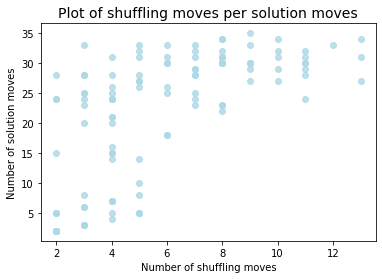

In [ ]:
plt.scatter(overallMoves, overallSolDepth, color = 'lightblue', alpha = 0.8)
plt.title("Plot of shuffling moves per solution moves", fontsize = 14)
plt.xlabel("Number of shuffling moves")
plt.ylabel("Number of solution moves")
plt.show()

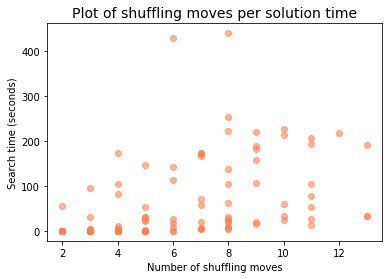

In [ ]:
plt.scatter(overallMoves, overallTime, color = 'coral', alpha = 0.6)
plt.title("Plot of shuffling moves per solution time", fontsize = 14)
plt.ylabel("Search time (seconds)")
plt.xlabel("Number of shuffling moves")
plt.show()

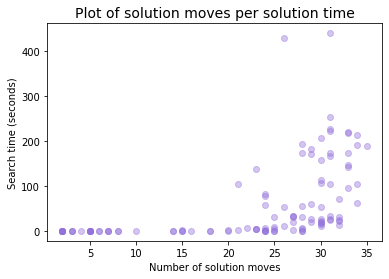

In [ ]:
plt.scatter(overallSolDepth, overallTime, color = 'mediumpurple', alpha = 0.4)
plt.title("Plot of solution moves per solution time", fontsize = 14)
plt.ylabel("Search time (seconds)")
plt.xlabel("Number of solution moves")
plt.show()

In [ ]:
df = pd.DataFrame({ "MoveList": overallMoves, "SoluList": overallSolDepth, "TimeList": overallTime})
groupedMoveSolu = df.groupby(pd.cut(df["MoveList"], np.arange(0, 15, 2))).mean()["SoluList"]
groupedSolutionTime = df.groupby(pd.cut(df["SoluList"], np.arange(0, 37, 4))).mean()["TimeList"]

In [ ]:
groupedMoveSolu

MoveList
(0, 2]       8.133333
(2, 4]      17.242424
(4, 6]      22.000000
(6, 8]      28.826087
(8, 10]     30.583333
(10, 12]    29.625000
(12, 14]    30.666667
Name: SoluList, dtype: float64

In [ ]:
groupedSolutionTime

SoluList
(0, 4]        0.003608
(4, 8]        0.034108
(8, 12]       0.008632
(12, 16]      0.714624
(16, 20]      0.927097
(20, 24]     32.613420
(24, 28]     53.346248
(28, 32]     98.219970
(32, 36]    159.963822
Name: TimeList, dtype: float64